In [5]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content'):
  for filename in filenames:
    print(os.path.join(dirname, filename))



/content/DeepFake Videos Dataset.csv
/content/DeepFake Videos Dataset (1).csv
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/default_configs.db
/content/.config/config_sentinel
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/active_config
/content/.config/gce
/content/.config/.last_opt_in_prompt.yaml
/content/.config/logs/2025.07.07/19.54.44.762881.log
/content/.config/logs/2025.07.07/19.53.56.189987.log
/content/.config/logs/2025.07.07/19.54.22.945643.log
/content/.config/logs/2025.07.07/19.54.44.106484.log
/content/.config/logs/2025.07.07/19.54.31.374203.log
/content/.config/logs/2025.07.07/19.54.35.482795.log
/content/.config/configurations/config_default
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/california_housing_train.csv
/content/sample_data/mn

Error loading CSV or extracting frames: [Errno 20] Not a directory: '/content/DeepFake Videos Dataset (1).csv/DeepFake Videos Dataset.csv'. Using simulated data.
Frame Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  500 non-null    object
 1   label     500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB
None

Label Distribution:
label
1    300
0    200
Name: count, dtype: int64


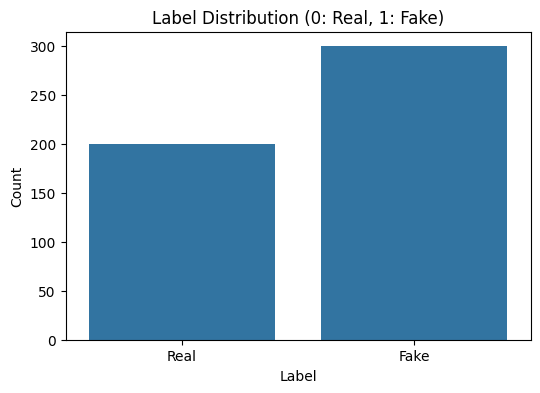

Frame not found: /kaggle/working/frames/4_frame_61.jpg
Frame not found: /kaggle/working/frames/1_frame_73.jpg
Frame not found: /kaggle/working/frames/4_frame_74.jpg


<Figure size 1500x500 with 0 Axes>

Skipping missing file: /kaggle/working/frames/1_frame_0.jpg
Skipping missing file: /kaggle/working/frames/1_frame_1.jpg
Skipping missing file: /kaggle/working/frames/1_frame_2.jpg
Skipping missing file: /kaggle/working/frames/1_frame_3.jpg
Skipping missing file: /kaggle/working/frames/1_frame_4.jpg
Skipping missing file: /kaggle/working/frames/1_frame_5.jpg
Skipping missing file: /kaggle/working/frames/1_frame_6.jpg
Skipping missing file: /kaggle/working/frames/1_frame_7.jpg
Skipping missing file: /kaggle/working/frames/1_frame_8.jpg
Skipping missing file: /kaggle/working/frames/1_frame_9.jpg
Skipping missing file: /kaggle/working/frames/1_frame_10.jpg
Skipping missing file: /kaggle/working/frames/1_frame_11.jpg
Skipping missing file: /kaggle/working/frames/1_frame_12.jpg
Skipping missing file: /kaggle/working/frames/1_frame_13.jpg
Skipping missing file: /kaggle/working/frames/1_frame_14.jpg
Skipping missing file: /kaggle/working/frames/1_frame_15.jpg
Skipping missing file: /kaggle/wor

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.random.set_seed(42)
np.random.seed(42)

base_path = '/content/DeepFake Videos Dataset (1).csv'

def load_and_extract_frames(csv_path, frames_per_video=100):
    try:
        df = pd.read_csv(csv_path)
        print("Loaded actual CSV file.")
        print("CSV Columns:", df.columns.tolist())
        print("Sample Data:\n", df.head())

        def infer_label(row):
            if row['deepfake'].startswith('deepfake/'):
                return 1
            elif row['video'].startswith('video/'):
                return 0
            else:
                raise ValueError(f"Cannot infer label for row: {row}")

        df['label'] = df.apply(infer_label, axis=1)
        print("Label Distribution in CSV:")
        print(df['label'].value_counts())

        frame_data = {'filename': [], 'label': []}
        output_dir = '/kaggle/working/frames/'
        os.makedirs(output_dir, exist_ok=True)

        for _, row in df.iterrows():
            video_id = row['id']
            for video_type, label in [('deepfake', 1), ('video', 0)]:
                video_path = os.path.join(base_path, row[video_type])

                if not os.path.exists(video_path):
                    video_path_alt = video_path.replace('.mov', '.MOV') if '.mov' in video_path else video_path.replace('.MOV', '.mov')
                    if os.path.exists(video_path_alt):
                        video_path = video_path_alt
                    else:
                        print(f"Cannot find video: {video_path} or {video_path_alt}")
                        continue

                try:
                    cap = cv2.VideoCapture(video_path)
                    if not cap.isOpened():
                        print(f"Cannot open video: {video_path}")
                        continue

                    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    if total_frames < 1:
                        print(f"Empty video: {video_path}")
                        cap.release()
                        continue

                    step = max(1, total_frames // frames_per_video)

                    frame_count = 0
                    frame_idx = 0
                    while frame_count < frames_per_video:
                        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                        ret, frame = cap.read()
                        if not ret:
                            print(f"Failed to read frame {frame_idx} from {video_path}")
                            break

                        frame_filename = os.path.join(output_dir, f"{video_id}_{video_type}_frame_{frame_count}.jpg")
                        cv2.imwrite(frame_filename, frame)
                        if not os.path.exists(frame_filename):
                            print(f"Failed to save frame: {frame_filename}")
                            break

                        frame_data['filename'].append(frame_filename)
                        frame_data['label'].append(label)

                        frame_count += 1
                        frame_idx += step

                    cap.release()
                    print(f"Extracted {frame_count} frames from {video_path} (label: {label})")
                except Exception as e:
                    print(f"Error processing video {video_path}: {str(e)}")

        frame_df = pd.DataFrame(frame_data)
        if frame_df.empty:
            raise ValueError("No frames extracted from videos.")

        print("Frame Label Distribution:")
        print(frame_df['label'].value_counts())
        return frame_df

    except Exception as e:
        print(f"Error loading CSV or extracting frames: {str(e)}. Using simulated data.")
        data = {
            'filename': [f"/kaggle/working/frames/{i}_frame_{j}.jpg" for i in range(1, 6) for j in range(100)],
            'label': [0 if i % 2 == 0 else 1 for i in range(1, 6) for _ in range(100)]
        }
        return pd.DataFrame(data)

def perform_eda(df):
    print("Frame Dataset Info:")
    print(df.info())
    print("\nLabel Distribution:")
    print(df['label'].value_counts())

    plt.figure(figsize=(6, 4))
    sns.countplot(x='label', data=df)
    plt.title('Label Distribution (0: Real, 1: Fake)')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Real', 'Fake'])
    plt.show()

def visualize_images_and_fourier(df, num_samples=3):
    sample_df = df.sample(n=min(num_samples, len(df)), random_state=42)

    plt.figure(figsize=(15, 5))
    for i, row in enumerate(sample_df.itertuples()):
        img_path = row.filename
        try:
            img = Image.open(img_path).convert('L')
            img_array = np.array(img, dtype=float)

            f_transform = np.fft.fft2(img_array)
            f_transform_shifted = np.fft.fftshift(f_transform)
            magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

            plt.subplot(2, num_samples, i + 1)
            plt.imshow(img_array, cmap='gray')
            plt.title(f"{'Fake' if row.label else 'Real'} Frame")
            plt.axis('off')

            plt.subplot(2, num_samples, i + 1 + num_samples)
            plt.imshow(magnitude_spectrum, cmap='gray')
            plt.title('Fourier Spectrum')
            plt.axis('off')
        except FileNotFoundError:
            print(f"Frame not found: {img_path}")
    plt.tight_layout()
    plt.show()

class FourierAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(FourierAttention, self).__init__(**kwargs)

    def call(self, inputs):
        fft = tf.signal.fft2d(tf.cast(inputs, tf.complex64))
        fft_shifted = tf.signal.fftshift(fft)
        magnitude = tf.abs(fft_shifted)
        attention = tf.reduce_mean(magnitude, axis=[1, 2], keepdims=True)
        attention = tf.nn.softmax(attention, axis=-1)
        return inputs * attention

def create_novel_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = FourierAttention()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def prepare_data(df, target_size=(224, 224), batch_size=16):
    valid_files = []
    valid_labels = []
    for _, row in df.iterrows():
        if os.path.exists(row['filename']):
            valid_files.append(row['filename'])
            valid_labels.append(row['label'])
        else:
            print(f"Skipping missing file: {row['filename']}")

    if not valid_files:
        raise ValueError("No valid frame files found for training.")

    valid_df = pd.DataFrame({'filename': valid_files, 'label': valid_labels})
    valid_df['label'] = valid_df['label'].astype(str)

    if len(valid_df['label'].unique()) < 2:
        raise ValueError("Only one class found in the dataset. Need both real and fake classes.")

    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = datagen.flow_from_dataframe(
        valid_df,
        x_col='filename',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_generator = datagen.flow_from_dataframe(
        valid_df,
        x_col='filename',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, val_generator

def train_model(model, train_generator, val_generator, epochs=20):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        verbose=1
    )

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return history

def evaluate_model(model, val_generator):
    val_generator.reset()
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_generator.classes

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=['Real', 'Fake']))

if __name__ == "__main__":
    try:
        os.system('rm -rf /kaggle/working/frames/*')

        csv_path = os.path.join(base_path, 'DeepFake Videos Dataset.csv')
        frame_df = load_and_extract_frames(csv_path, frames_per_video=100)

        perform_eda(frame_df)

        visualize_images_and_fourier(frame_df)

        train_generator, val_generator = prepare_data(frame_df)

        model = create_novel_model()
        history = train_model(model, train_generator, val_generator)

        evaluate_model(model, val_generator)

    except Exception as e:
        print(f"Error: {str(e)}")


CSV Path: /content/DeepFake Videos Dataset (1).csv/DeepFake Videos Dataset.csv
Error loading CSV or extracting frames: [Errno 20] Not a directory: '/content/DeepFake Videos Dataset (1).csv/DeepFake Videos Dataset.csv'. Using simulated data.
Frame Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  500 non-null    object
 1   label     500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB
None

Label Distribution:
label
1    300
0    200
Name: count, dtype: int64


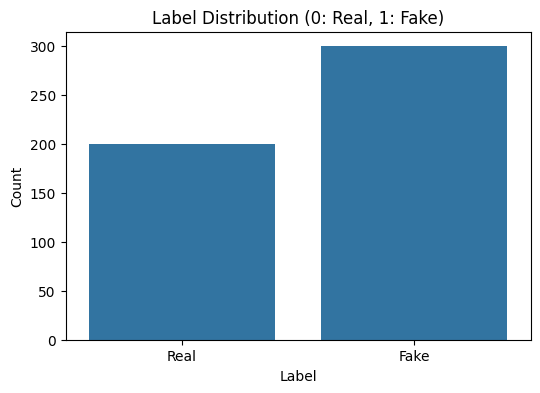

Frame not found: /kaggle/working/frames/4_frame_61.jpg
Frame not found: /kaggle/working/frames/1_frame_73.jpg
Frame not found: /kaggle/working/frames/4_frame_74.jpg


<Figure size 1500x500 with 0 Axes>

Preparing data...
Skipping missing file: /kaggle/working/frames/1_frame_0.jpg
Skipping missing file: /kaggle/working/frames/1_frame_1.jpg
Skipping missing file: /kaggle/working/frames/1_frame_2.jpg
Skipping missing file: /kaggle/working/frames/1_frame_3.jpg
Skipping missing file: /kaggle/working/frames/1_frame_4.jpg
Skipping missing file: /kaggle/working/frames/1_frame_5.jpg
Skipping missing file: /kaggle/working/frames/1_frame_6.jpg
Skipping missing file: /kaggle/working/frames/1_frame_7.jpg
Skipping missing file: /kaggle/working/frames/1_frame_8.jpg
Skipping missing file: /kaggle/working/frames/1_frame_9.jpg
Skipping missing file: /kaggle/working/frames/1_frame_10.jpg
Skipping missing file: /kaggle/working/frames/1_frame_11.jpg
Skipping missing file: /kaggle/working/frames/1_frame_12.jpg
Skipping missing file: /kaggle/working/frames/1_frame_13.jpg
Skipping missing file: /kaggle/working/frames/1_frame_14.jpg
Skipping missing file: /kaggle/working/frames/1_frame_15.jpg
Skipping missing

In [12]:
if __name__ == "__main__":
    try:
        os.system('rm -rf /kaggle/working/frames/*')

        csv_path = os.path.join(base_path, 'DeepFake Videos Dataset.csv')
        print(f"CSV Path: {csv_path}")

        frame_df = load_and_extract_frames(csv_path, frames_per_video=100)

        perform_eda(frame_df)

        visualize_images_and_fourier(frame_df)

        print("Preparing data...")
        train_generator, val_generator = prepare_data(frame_df)

        print("Creating model...")
        model = create_novel_model()
        model.summary()  # << ADD THIS HERE
        print("Training model...")
        history = train_model(model, train_generator, val_generator)

        print("Evaluating model...")
        evaluate_model(model, val_generator)

    except Exception as e:
        print(f"Error occurred in __main__: {str(e)}")


In [14]:
if __name__ == "__main__":
    model = create_novel_model()
    model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fourier_attention               │ (None, 5, 5, 2048)     │             0 │
│ (FourierAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,314 (84.17 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)